<a href="https://colab.research.google.com/github/ma55530/SemEval2026-CLARITY-FER/blob/model%2FBERT/notebooks/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing the necessary libraries**

In [ ]:
!pip -q install scikit-learn torch pandas datasets transformers

In [ ]:
import pandas as pd
from datasets import Dataset, load_dataset

# **Loading the data**

In [ ]:
print("Loading dataset...")
df = load_dataset("ailsntua/QEvasion")

def clarity_to_label(row) :
  mapping = {
      "Clear Reply": 0,
      "Ambivalent": 1,
      "Clear Non-Reply": 2
  }
  row["label"] = mapping[row["clarity_label"]]
  return row

df = df.map(clarity_to_label)
y_test = df["test"]["label"]




Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.90M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/259k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3448 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/308 [00:00<?, ? examples/s]

Map:   0%|          | 0/3448 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

# **Defining the evaluation**

In [ ]:
def evaluate(y_test, y_test_pred):
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import precision_recall_fscore_support

    print(classification_report(y_test, y_test_pred))

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_test_pred, average="micro"
    )
    print(f"Precision: {precision:6.2f}")
    print(f"   Recall: {recall:6.2f}")
    print(f"       F1: {f1:6.2f}")

    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    plt.show()
    return precision, recall, f1



# **Loading the model and tokenizer**

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer



model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=3
)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


from transformers import pipeline

# we want to cut texts longer than 512 tokens to be 512 tokens
clf = pipeline(
    "text-classification",
    model=model,
    tokenizer=lambda x, **kwargs: tokenizer(
        x,
        padding="max_length",
        max_length=512,
        truncation=True,
        return_tensors="pt",
    ),
    device=0, # use GPU
)




config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cuda:0


# **Preparing the data for training**

In [ ]:
#tokenization, no longer than 512 tokens
tokenized_train = df["train"].map(
    lambda x: tokenizer(
        "Question: " + x["interview_question"] + " Answer: " + x["interview_answer"],
        padding="max_length",
        max_length=512,
        truncation=True
    ),
    batched=False
)

tokenized_test = df["test"].map(
    lambda x: tokenizer(
        "Question: " + x["interview_question"] + " Answer: " + x["interview_answer"],
        padding="max_length",
        max_length=512,
        truncation=True
    ),
    batched=False
)


Map:   0%|          | 0/3448 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

# **Defining the evaluation function and training**

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.769213,0.668831,0.668831,0.668831
2,0.875900,0.729182,0.691558,0.691558,0.691558
3,0.729600,0.749558,0.678571,0.678571,0.678571


              precision    recall  f1-score   support

           0       0.50      0.09      0.15        79
           1       0.69      0.95      0.80       206
           2       0.33      0.13      0.19        23

    accuracy                           0.67       308
   macro avg       0.51      0.39      0.38       308
weighted avg       0.61      0.67      0.59       308

Precision:   0.67
   Recall:   0.67
       F1:   0.67


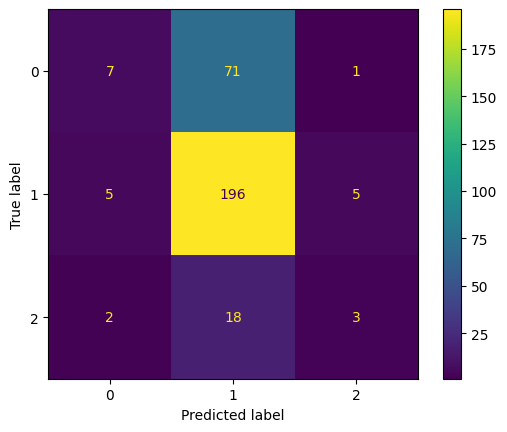

              precision    recall  f1-score   support

           0       0.48      0.32      0.38        79
           1       0.75      0.85      0.80       206
           2       0.57      0.52      0.55        23

    accuracy                           0.69       308
   macro avg       0.60      0.56      0.58       308
weighted avg       0.67      0.69      0.67       308

Precision:   0.69
   Recall:   0.69
       F1:   0.69


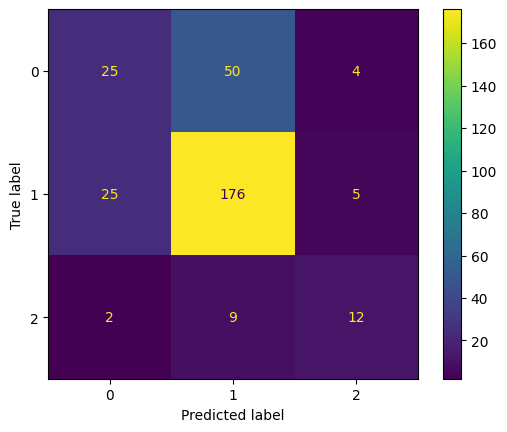

              precision    recall  f1-score   support

           0       0.46      0.27      0.34        79
           1       0.72      0.86      0.79       206
           2       0.62      0.43      0.51        23

    accuracy                           0.68       308
   macro avg       0.60      0.52      0.55       308
weighted avg       0.65      0.68      0.65       308

Precision:   0.68
   Recall:   0.68
       F1:   0.68


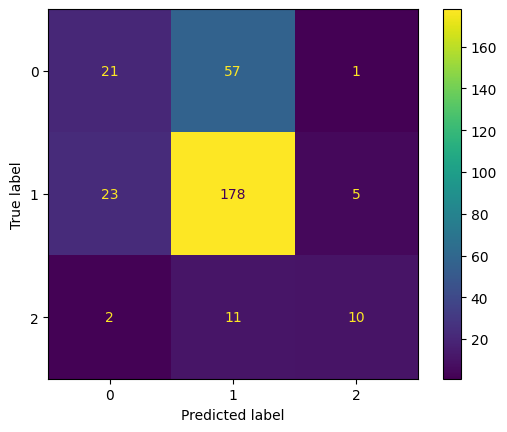

TrainOutput(global_step=1293, training_loss=0.756331016735245, metrics={'train_runtime': 392.1873, 'train_samples_per_second': 26.375, 'train_steps_per_second': 3.297, 'total_flos': 2721645192978432.0, 'train_loss': 0.756331016735245, 'epoch': 3.0})

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


def compute_metrics(eval_pred):
    import numpy as np

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    p, r, f1 = evaluate(y_test, predictions)
    return {"precision": p, "recall": r, "f1": f1}



# train model
from transformers import Trainer, TrainingArguments

trainer = Trainer(
    model=model,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
    args=TrainingArguments(
        num_train_epochs=3,
        eval_strategy="epoch",
        eval_steps=1,
        output_dir="output",
        seed=42,
        fp16=True,
    ),
)

trainer.train()